In this notebook, we will attempt to apply another type of text-data preprocessing viz. TF-IDF based vectorization. We will also try a simple neural network model to see if we can improve the baseline score. 

We could have gone for sequence models by incorporating word embeddings but the corpus that we are dealing with is not very large and experiments say that in these cases n-gram models perform better. Another reason behind not using word embeddings is embedding relationships are learned in dense space, and this happens best over many samples (i.e. a very very large corpora).

In [2]:
#Dependencies
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings("ignore")

During our previous experiments, we serialized the shorter versions of the train and test sets. Let's load them.

In [2]:
new_train_frame = pd.read_csv('new_train_frame.csv', encoding = "ISO-8859-1")
new_test_frame = pd.read_csv('new_test_frame.csv', encoding = "ISO-8859-1")

## Splitting into train and validation sets (80:20) - 

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(new_train_frame['TRANS_CONV_TEXT'], new_train_frame['Patient_Tag'], \
                                                    test_size=0.2, random_state=42)

## Data preprocessing with TF-IDF vectorization - 

We can write utility functions for this which in turns gives our code a modular approach. 

In [4]:
# Vectorization parameters
# Range (inclusive) of n-gram sizes for tokenizing text.
NGRAM_RANGE = (1, 2)

# Whether text should be split into word or character n-grams.
# One of 'word', 'char'.
TOKEN_MODE = 'word'

# Minimum document/corpus frequency below which a token will be discarded.
MIN_DOCUMENT_FREQUENCY = 2

def ngram_vectorize(train_texts, train_labels, val_texts):
    """
    # Arguments
        train_texts: list, training text strings.
        train_labels: np.ndarray, training labels.
        val_texts: list, validation text strings.

    # Returns
        x_train, x_val: vectorized training and validation texts
    """
    # Create keyword arguments to pass to the 'tf-idf' vectorizer.
    kwargs = {
            'ngram_range': NGRAM_RANGE,  # Use 1-grams + 2-grams.
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': TOKEN_MODE,  # Split text into word tokens.
            'min_df': MIN_DOCUMENT_FREQUENCY,
    }
    vectorizer = TfidfVectorizer(**kwargs)

    # Learn vocabulary from training texts and vectorize training texts.
    x_train = vectorizer.fit_transform(train_texts)

    # Vectorize validation texts.
    x_val = vectorizer.transform(val_texts)
    
    return x_train, x_val

## Building an MLP model

We are dealing with a binary classification problem so the activation function for the output layer of the network will be `sigmoid` as it will give us the class probabilities which we can eventually convert to discrete classes. 

The following function `get_last_layer_units_and_activation()` is responsible for - 
* Determining the activation function for the output layer.
* Number of units to be present in the output layer. 

The function can also be extended to multinomial classification tasks as well (where `softmax` activation function is used in the last layer). 

In [5]:
def get_last_layer_units_and_activation(num_classes):
    """Gets the # units and activation function for the last network layer.

    # Arguments
        num_classes: int, number of classes.

    # Returns
        units, activation values.
    """
    if num_classes == 2:
        activation = 'sigmoid'
        units = 1
    else:
        activation = 'softmax'
        units = num_classes
    return units, activation

The following method builds us a feed-forward network. 

In [6]:
from tensorflow.python.keras import models
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout

def mlp_model(layers, units, dropout_rate, input_shape, num_classes):
    """Creates an instance of a multi-layer perceptron model.

    # Arguments
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of the layers.
        dropout_rate: float, percentage of input to drop at Dropout layers.
        input_shape: tuple, shape of input to the model.
        num_classes: int, number of output classes.

    # Returns
        An MLP model instance.
    """
    op_units, op_activation = get_last_layer_units_and_activation(num_classes)
    model = models.Sequential()
    model.add(Dropout(rate=dropout_rate, input_shape=input_shape))

    for _ in range(layers-1):
        model.add(Dense(units=units, activation='relu'))
        model.add(Dropout(rate=dropout_rate))

    model.add(Dense(units=op_units, activation=op_activation))
    return model

`train_ngram_model()` function helps to train and validate our shallow network.  

In [5]:
import tensorflow as tf 

def train_ngram_model(data,
                      learning_rate=1e-3,
                      epochs=1000,
                      batch_size=128,
                      layers=3,
                      units=64,
                      dropout_rate=0.2):
    # Get the data.
    (train_texts, train_labels), (val_texts, val_labels) = data

    # Specify the number of classes.
    num_classes = 2

    # Vectorize texts.
    x_train, x_val = ngram_vectorize(
        train_texts, train_labels, val_texts)

    # Instantiate the model
    model = mlp_model(layers=layers,
                                  units=units,
                                  dropout_rate=dropout_rate,
                                  input_shape=x_train.shape[1:],
                                  num_classes=num_classes)

    # Compile model with learning parameters.
    loss = 'binary_crossentropy'
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])

    # Create callback for early stopping on validation loss. If the loss does
    # not decrease in two consecutive tries, stop training.
    # Tensorboard callback for debugging purpose
    callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=2), tf.keras.callbacks.TensorBoard(log_dir='./logs')]

    # Train and validate model.
    history = model.fit(
            x_train,
            train_labels,
            epochs=epochs,
            callbacks=callbacks,
            validation_data=(x_val, val_labels),
            verbose=2,  # Logs once per epoch.
            batch_size=batch_size)

    # Print results.
    history = history.history
    print('Validation accuracy: {acc}, loss: {loss}'.format(
            acc=history['val_acc'][-1], loss=history['val_loss'][-1]))

    # Save model.
    model.save('zs_mlp_model.h5')
    return history

<b>A note on the model configuration choices</b>:
* **Dropout layers**: For reducing overfitting. Its value is set 0.2 which means that 20% of the input data will be randomly chosen and excluded from successive activations. This [blog](https://machinelearningmastery.com/how-to-reduce-overfitting-with-dropout-regularization-in-keras/) provides a gentle introduction to dropout regularization. 
* **Loss function**: We used `binary_crossentropy` as our loss function which is a pretty standard one when it comes to binary classification. It is also convex in nature which in turn helps the optimization algorithm in a faster convergence. 
* **Adam optimizer**: Stochastic gradient descent maintains a single learning rate (termed alpha) for all weight updates and the learning rate does not change during training.Whereas in Adam, a learning rate is maintained for each network weight (parameter) and separately adapted as learning unfolds.The method computes individual adaptive learning rates for different parameters from estimates of first and second moments of the gradients.

## Training and evaluating the MLP model

#### Preparing the data for fitting it to a feed-forward network - 

In [8]:
data = ((list(X_train), np.array(y_train)), (list(X_valid), np.array(y_valid)))

#### Training a feed-forward networks - 

In [18]:
h = train_ngram_model(data,\
                      learning_rate=1e-3,\
                      epochs=1000,\
                      batch_size=128,\
                      layers=3,\
                      units=64,\
                      dropout_rate=0.2)

Train on 924 samples, validate on 232 samples
Epoch 1/1000
 - 1s - loss: 0.6765 - acc: 0.7468 - val_loss: 0.6409 - val_acc: 0.7716
Epoch 2/1000
 - 1s - loss: 0.6013 - acc: 0.7976 - val_loss: 0.5652 - val_acc: 0.7716
Epoch 3/1000
 - 1s - loss: 0.5050 - acc: 0.7976 - val_loss: 0.4893 - val_acc: 0.7716
Epoch 4/1000
 - 1s - loss: 0.4076 - acc: 0.7976 - val_loss: 0.4266 - val_acc: 0.7716
Epoch 5/1000
 - 1s - loss: 0.3183 - acc: 0.8106 - val_loss: 0.3668 - val_acc: 0.7888
Epoch 6/1000
 - 1s - loss: 0.2383 - acc: 0.9080 - val_loss: 0.3155 - val_acc: 0.8190
Epoch 7/1000
 - 1s - loss: 0.1774 - acc: 0.9784 - val_loss: 0.2778 - val_acc: 0.8621
Epoch 8/1000
 - 1s - loss: 0.1250 - acc: 0.9903 - val_loss: 0.2604 - val_acc: 0.8922
Epoch 9/1000
 - 1s - loss: 0.0818 - acc: 0.9989 - val_loss: 0.2424 - val_acc: 0.9138
Epoch 10/1000
 - 1s - loss: 0.0489 - acc: 0.9989 - val_loss: 0.2232 - val_acc: 0.9095
Epoch 11/1000
 - 1s - loss: 0.0306 - acc: 0.9989 - val_loss: 0.2111 - val_acc: 0.9181
Epoch 12/1000
 - 

    The validation accuracy has increased to a good extent with a shallow net. 

#### Plotting and summarization of loss and accuracy - 

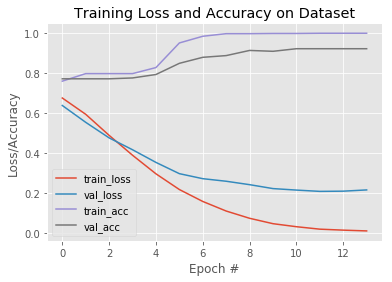

In [10]:
# Plot the training loss and accuracy.
import matplotlib.pyplot as plt

%matplotlib inline
 
# Plot
N = len(h['loss'])
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), h["loss"], label="train_loss")
plt.plot(np.arange(0, N), h["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), h["acc"], label="train_acc")
plt.plot(np.arange(0, N), h["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

## Deriving the confusion matrix with the help of the serialized model

In [3]:
# Loading the model weigths

import keras
from keras.models import load_model
from keras.utils import CustomObjectScope
from keras.initializers import glorot_uniform

with CustomObjectScope({'GlorotUniform': glorot_uniform()}):
        model = load_model('zs_mlp_model.h5') # We serialized the weights of the feed-forward network

We used `CustomObjectScope` to load up the `model.h5` file since there were compatibility issues. The `CustomObjectScope` needs an instance to be passed hence the use of the `gloroth_uniform` initializer. It does not have any other special purpose. 

Stackoverflow thread referred for this: https://stackoverflow.com/questions/53183865/unknown-initializer-glorotuniform-when-loading-keras-model

In [20]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

_, validation_vectors = ngram_vectorize(
        list(X_train), np.array(y_train), list(X_valid))
valid_preds = model.predict_classes(validation_vectors)
print(classification_report(y_valid, valid_preds))

             precision    recall  f1-score   support

          0       0.92      0.98      0.95       179
          1       0.93      0.72      0.81        53

avg / total       0.92      0.92      0.92       232



Our MLP model beats the baseline when it comes to identifying the minority classes. 

We can now use this model to make predictions on the actual test set. 

In [14]:
_, test_vectors = ngram_vectorize(
        list(X_train), np.array(y_train), list(new_test_frame['TRANS_CONV_TEXT']))

In [15]:
test_preds = model.predict_classes(test_vectors)

Here's the architecture of the model that we used - 

In [7]:
tf.keras.utils.plot_model(model,to_file='model.png',show_shapes=True, show_layer_names=True)

![](model.png)

The first node denotes the inputs. 

## Preparing the submission file

In [ ]:
test_for_submission = pd.read_csv('../dataset/test.csv', encoding = "ISO-8859-1")
submission = pd.DataFrame()
submission['Index'] = test_for_submission['Index']
submission['Patient_Tag'] = test_preds

submission.to_csv('submission03.csv',index=False)

In [ ]:
!head -5 submission03.csv

### Further considerations - 

* Hyperparameter tuning.
* Prediction ensembles. 
* Build a simple REST API of the shallow net so that it can be deployed in production. 